In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import shap

# import dataset

current_os = 'mac'
if current_os == 'mac':
    path = '/Users/fabienaugsburger/Documents/GitHub/master-project/'
elif current_os == 'win':
    path = 'C:/Users/fabau/OneDrive/Documents/GitHub/master-project/'
else:
    print('Error: OS not recognized')

# load data

dataset = 'X_y'
osaa = 2

if osaa == '':
    X_train = np.load(path + f'DATASETS/{dataset}/X_train.npy')
    X_test = np.load(path + f'DATASETS/{dataset}/X_test.npy')
    y_train = np.load(path + f'DATASETS/{dataset}/y_train.npy')
    y_test = np.load(path + f'DATASETS/{dataset}/y_test.npy')
    X_validation = np.load(path + f'DATASETS/{dataset}/X_validation.npy')
    y_validation = np.load(path + f'DATASETS/{dataset}/y_validation.npy')
else:
    X_train = np.load(path + f'DATASETS/{dataset}/X_train_{osaa}.npy')
    X_test = np.load(path + f'DATASETS/{dataset}/X_test_{osaa}.npy')
    y_train = np.load(path + f'DATASETS/{dataset}/y_train_{osaa}.npy')
    y_test = np.load(path + f'DATASETS/{dataset}/y_test_{osaa}.npy')
    X_validation = np.load(path + f'DATASETS/{dataset}/X_validation_{osaa}.npy')
    y_validation = np.load(path + f'DATASETS/{dataset}/y_validation_{osaa}.npy')



names = pd.read_csv(path + f'variable_list_24_v5_wo_i.csv')

if osaa == 2:
    X_train=pd.DataFrame(X_train, columns=names['variables'])
    X_test=pd.DataFrame(X_test, columns=names['variables'])
    X_validation=pd.DataFrame(X_validation, columns=names['variables'])
    
    y_train=pd.DataFrame(y_train, columns=['instantaneous_10m_wind_gust_0'])
    y_test=pd.DataFrame(y_test, columns=['instantaneous_10m_wind_gust_0'])
    y_validation=pd.DataFrame(y_validation, columns=['instantaneous_10m_wind_gust_0'])

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
y_validation = y_validation.values.ravel()

# List of regressors to test
regressors = {
    'RandomForest': RandomForestRegressor(),
    'LightGBM': LGBMRegressor(),
    'XGBoost': XGBRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge()
}

# Function to evaluate a regressor and plot SHAP values
def evaluate_regressor(regressor, X_train, y_train, X_test, y_test):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    #explainer = shap.Explainer(regressor, X_train)
    #shap_values = explainer(X_test)
    #shap.summary_plot(shap_values, X_test)
    
    return mse

# Evaluate all regressors
results = {}
for name, regressor in regressors.items():
    print(f"Evaluating {name}...")
    mse = evaluate_regressor(regressor, X_train, y_train, X_test, y_test)
    results[name] = mse

# Display results
results_df = pd.DataFrame(list(results.items()), columns=['Regressor', 'MSE'])
print(results_df)

Evaluating RandomForest...
Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
Evaluating XGBoost...
Evaluating GradientBoosting...
Evaluating LinearRegression...
Evaluating Ridge...
          Regressor       MSE
0      RandomForest  5.258859
1          LightGBM  4.582937
2           XGBoost  5.161609
3  GradientBoosting  4.991311
4  LinearRegression  4.596555
5             Ridge  5.699053


In [2]:
import optuna
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from optuna.samplers import TPESampler

# Define objective functions for each regressor

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store additional metrics as attributes of the trial
    trial.set_user_attr("mae", mae)
    trial.set_user_attr("r2", r2)
    
    return mse  # Optimize using MSE

def objective_lgbm(trial):
    num_leaves = trial.suggest_int('num_leaves', 10, 200)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    
    model = LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    trial.set_user_attr("mae", mae)
    trial.set_user_attr("r2", r2)
    
    return mse  # Optimize using MSE

def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    trial.set_user_attr("mae", mae)
    trial.set_user_attr("r2", r2)
    
    return mse  # Optimize using MSE

def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    trial.set_user_attr("mae", mae)
    trial.set_user_attr("r2", r2)
    
    return mse  # Optimize using MSE

def objective_lr(trial):
    model = LinearRegression()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    trial.set_user_attr("mae", mae)
    trial.set_user_attr("r2", r2)
    
    return mse  # Optimize using MSE

def objective_ridge(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-3, 10.0)
    
    model = Ridge(alpha=alpha, random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    trial.set_user_attr("mae", mae)
    trial.set_user_attr("r2", r2)
    
    return mse  # Optimize using MSE

# Dictionary to hold the studies for each model
studies = {
    'RandomForest': optuna.create_study(direction='minimize', sampler=TPESampler()),
    'LightGBM': optuna.create_study(direction='minimize', sampler=TPESampler()),
    'XGBoost': optuna.create_study(direction='minimize', sampler=TPESampler()),
    'GradientBoosting': optuna.create_study(direction='minimize', sampler=TPESampler()),
    'LinearRegression': optuna.create_study(direction='minimize', sampler=TPESampler()),
    'Ridge': optuna.create_study(direction='minimize', sampler=TPESampler())
}

# Dictionary to map models to their objective functions
objectives = {
    'RandomForest': objective_rf,
    'LightGBM': objective_lgbm,
    'XGBoost': objective_xgb,
    'GradientBoosting': objective_gb,
    'LinearRegression': objective_lr,
    'Ridge': objective_ridge
}

# Run the optimization for each regressor
for name, study in studies.items():
    print(f"Optimizing {name}...")
    study.optimize(objectives[name], n_trials=100, n_jobs=6)
    best_trial = study.best_trial
    print(f"Best hyperparameters for {name}: {best_trial.params}")
    print(f"Best MSE for {name}: {best_trial.value}")
    print(f"Best MAE for {name}: {best_trial.user_attrs['mae']}")
    print(f"Best R2 for {name}: {best_trial.user_attrs['r2']}")

# Print all the best hyperparameters and their MSEs
for name, study in studies.items():
    best_trial = study.best_trial
    print(f"\n{name} best hyperparameters: {best_trial.params}")
    print(f"{name} best MSE: {best_trial.value}")
    print(f"{name} best MAE: {best_trial.user_attrs['mae']}")
    print(f"{name} best R2: {best_trial.user_attrs['r2']}")

[I 2024-09-19 10:27:18,356] A new study created in memory with name: no-name-849ed517-134c-46df-9a63-7be5b46ca3e5
[I 2024-09-19 10:27:18,357] A new study created in memory with name: no-name-314aef3e-d847-4972-98c5-92276d9a6e4f
[I 2024-09-19 10:27:18,357] A new study created in memory with name: no-name-8c7964a2-e3c8-4bab-92c0-71fdf44fefdd
[I 2024-09-19 10:27:18,358] A new study created in memory with name: no-name-39668ebf-925b-4f72-9c9f-032415fa703f
[I 2024-09-19 10:27:18,358] A new study created in memory with name: no-name-5125d8e7-b190-4fbb-9a03-e80905024fcf
[I 2024-09-19 10:27:18,359] A new study created in memory with name: no-name-20c6fc07-529f-4c55-baad-6b877ce187a3
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was exp

Optimizing RandomForest...


[I 2024-09-19 10:27:30,319] Trial 5 finished with value: 7.446296416760162 and parameters: {'n_estimators': 63, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 5 with value: 7.446296416760162.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[I 2024-09-19 10:27:34,932] Trial 3 finished with value: 5.294530851755683 and parameters: {'n_estimators': 46, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 3 with value: 5.294530851755683.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[I 2024-09-19 10:27:41,023] Trial 1 finished with value: 7.375460649162371 and parameters: {'n_estimators': 120, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 3 with value: 5.294530851755683.
A column-vector y was passed when a 1d array was expected. Please

Best hyperparameters for RandomForest: {'n_estimators': 85, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}
Best MSE for RandomForest: 5.1229825177680395
Best MAE for RandomForest: 1.7153928021578304
Best R2 for RandomForest: 0.8588145236643321
Optimizing LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing 

[I 2024-09-19 10:37:48,881] Trial 4 finished with value: 5.270389748382109 and parameters: {'num_leaves': 68, 'max_depth': 5, 'learning_rate': 0.23103835313173632, 'n_estimators': 16}. Best is trial 4 with value: 5.270389748382109.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:37:53,252] Trial 2 finished with value: 4.787795947227904 and parameters: {'num_leaves': 60, 'max_depth': 9, 'learning_rate': 0.12277492512670422, 'n_estimators': 52}. Best is trial 2 with value: 4.787795947227904.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:37:53,937] Trial 7 finished with value: 7.284056094592241 and parameters: {'num_leaves': 10, 'max_depth': 18, 'learning_rate': 0.0450496823819645, 'n_estimators': 44}. Best is trial 2 with value: 4.787795947227904.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:37:54,243] Trial 8 finished with value: 13.590651967091244 and parameters: {'num_leaves': 183, 'max_depth': 2, 'learning_rate': 0.0310850210647185, 'n_estimators': 39}. Best is trial 2 with value: 4.787795947227904.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:37:57,725] Trial 3 finished with value: 5.187361419726125 and parameters: {'num_leaves': 44, 'max_depth': 6, 'learning_rate': 0.016122010073231788, 'n_estimators': 184}. Best is trial 2 with value: 4.787795947227904.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-19 10:38:05,107] Trial 5 finished with value: 4.722742607762655 and parameters: {'num_leaves': 58, 'max_depth': 12, 'learning_rate': 0.03262822129324322, 'n_estimators': 172}. Best is trial 5 with value: 4.722742607762655.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:38:05,324] Trial 11 finished with value: 20.342882296239782 and parameters: {'num_leaves': 168, 'max_depth': 3, 'learning_rate': 0.03263372956495093, 'n_estimators': 15}. Best is trial 5 with value: 4.722742607762655.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-19 10:38:05,836] Trial 9 finished with value: 5.4901403153747514 and parameters: {'num_leaves': 155, 'max_depth': 18, 'learning_rate': 0.29055049722590204, 'n_estimators': 62}. Best is trial 5 with value: 4.722742607762655.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-19 10:38:10,099] Trial 12 finished with value: 4.903249053117583 and parameters: {'num_leaves': 145, 'max_depth': 5, 'learning_rate': 0.29594789097446433, 'n_estimators': 166}. Best is trial 5 with value: 4.722742607762655.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-19 10:38:10,627] Trial 0 finished with value: 5.049900110917195 and parameters: {'num_leaves': 184, 'max_depth': 11, 'learning_rate': 0.07649636114246694, 'n_estimators': 92}. Best is trial 5 with value: 4.722742607762655.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-19 10:38:13,122] Trial 14 finished with value: 9.157793033861791 and parameters: {'num_leaves': 74, 'max_depth': 6, 'learning_rate': 0.02868043361346501, 'n_estimators': 40}. Best is trial 5 with value: 4.722742607762655.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:38:14,214] Trial 1 finished with value: 5.116161155371496 and parameters: {'num_leaves': 195, 'max_depth': 15, 'learning_rate': 0.0487133131119939, 'n_estimators': 98}. Best is trial 5 with value: 4.722742607762655.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-19 10:38:17,873] Trial 13 finished with value: 5.150478848645186 and parameters: {'num_leaves': 82, 'max_depth': 20, 'learning_rate': 0.21186983463543888, 'n_estimators': 105}. Best is trial 5 with value: 4.722742607762655.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-19 10:38:19,270] Trial 6 finished with value: 5.268239637095012 and parameters: {'num_leaves': 156, 'max_depth': 19, 'learning_rate': 0.15304202644862713, 'n_estimators': 159}. Best is trial 5 with value: 4.722742607762655.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:38:19,601] Trial 10 finished with value: 5.20046859804923 and parameters: {'num_leaves': 146, 'max_depth': 8, 'learning_rate': 0.02563371708732585, 'n_estimators': 115}. Best is trial 5 with value: 4.722742607762655.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-19 10:38:32,352] Trial 17 finished with value: 5.001256482202929 and parameters: {'num_leaves': 112, 'max_depth': 11, 'learning_rate': 0.10953608995607145, 'n_estimators': 137}. Best is trial 5 with value: 4.722742607762655.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-19 10:38:34,025] Trial 15 finished with value: 6.711623013523722 and parameters: {'num_leaves': 109, 'max_depth': 14, 'learning_rate': 0.011147561591149173, 'n_estimators': 146}. Best is trial 5 with value: 4.722742607762655.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:38:34,754] Trial 16 finished with value: 4.898423532111181 and parameters: {'num_leaves': 112, 'max_depth': 12, 'learning_rate': 0.11078963253447875, 'n_estimators': 134}. Best is trial 5 with value: 4.722742607762655.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-19 10:38:37,171] Trial 19 finished with value: 4.814720790785484 and parameters: {'num_leaves': 111, 'max_depth': 11, 'learning_rate': 0.1113046727280768, 'n_estimators': 136}. Best is trial 5 with value: 4.722742607762655.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-19 10:38:38,645] Trial 20 finished with value: 4.937075490096881 and parameters: {'num_leaves': 112, 'max_depth': 12, 'learning_rate': 0.09283785482477518, 'n_estimators': 133}. Best is trial 5 with value: 4.722742607762655.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:38:40,143] Trial 18 finished with value: 4.856049992060232 and parameters: {'num_leaves': 120, 'max_depth': 10, 'learning_rate': 0.09467480629913726, 'n_estimators': 145}. Best is trial 5 with value: 4.722742607762655.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:38:40,281] Trial 23 finished with value: 4.748153858053562 and parameters: {'num_leaves': 45, 'max_depth': 9, 'learning_rate': 0.07275200033974188, 'n_estimators': 80}. Best is trial 5 with value: 4.722742607762655.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:38:43,323] Trial 21 finished with value: 5.82502834673057 and parameters: {'num_leaves': 34, 'max_depth': 14, 'learning_rate': 0.010764888403718474, 'n_estimators': 200}. Best is trial 5 with value: 4.722742607762655.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:38:45,078] Trial 27 finished with value: 4.896832387471876 and parameters: {'num_leaves': 42, 'max_depth': 8, 'learning_rate': 0.06294685009519516, 'n_estimators': 76}. Best is trial 5 with value: 4.722742607762655.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:38:46,700] Trial 22 finished with value: 4.504138394577198 and parameters: {'num_leaves': 37, 'max_depth': 9, 'learning_rate': 0.07978679000086053, 'n_estimators': 199}. Best is trial 22 with value: 4.504138394577198.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:38:47,263] Trial 24 finished with value: 4.613141402817721 and parameters: {'num_leaves': 35, 'max_depth': 8, 'learning_rate': 0.07052723667472698, 'n_estimators': 199}. Best is trial 22 with value: 4.504138394577198.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:38:49,801] Trial 28 finished with value: 4.808915663758902 and parameters: {'num_leaves': 51, 'max_depth': 8, 'learning_rate': 0.06434965423286206, 'n_estimators': 75}. Best is trial 22 with value: 4.504138394577198.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:38:50,532] Trial 25 finished with value: 4.586049323901049 and parameters: {'num_leaves': 36, 'max_depth': 8, 'learning_rate': 0.0675226701497229, 'n_estimators': 196}. Best is trial 22 with value: 4.504138394577198.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:38:50,642] Trial 29 finished with value: 4.669255036750791 and parameters: {'num_leaves': 56, 'max_depth': 9, 'learning_rate': 0.14920514515961614, 'n_estimators': 70}. Best is trial 22 with value: 4.504138394577198.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:38:52,359] Trial 31 finished with value: 5.066480977849928 and parameters: {'num_leaves': 12, 'max_depth': 16, 'learning_rate': 0.021013064810728472, 'n_estimators': 198}. Best is trial 22 with value: 4.504138394577198.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:38:52,769] Trial 26 finished with value: 4.577561352561261 and parameters: {'num_leaves': 45, 'max_depth': 9, 'learning_rate': 0.06370268449086351, 'n_estimators': 191}. Best is trial 22 with value: 4.504138394577198.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:38:54,315] Trial 32 finished with value: 4.547610917056659 and parameters: {'num_leaves': 13, 'max_depth': 15, 'learning_rate': 0.040250267928406955, 'n_estimators': 197}. Best is trial 22 with value: 4.504138394577198.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:38:54,412] Trial 30 finished with value: 4.256884564484454 and parameters: {'num_leaves': 27, 'max_depth': 16, 'learning_rate': 0.0627309926717374, 'n_estimators': 169}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:38:55,841] Trial 33 finished with value: 4.335428043344812 and parameters: {'num_leaves': 16, 'max_depth': 7, 'learning_rate': 0.043021493577416595, 'n_estimators': 199}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:38:57,852] Trial 34 finished with value: 4.44798838516528 and parameters: {'num_leaves': 19, 'max_depth': 6, 'learning_rate': 0.04471963524872071, 'n_estimators': 200}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:38:59,386] Trial 35 finished with value: 4.582495477021536 and parameters: {'num_leaves': 25, 'max_depth': 6, 'learning_rate': 0.04341505196557409, 'n_estimators': 183}. Best is trial 30 with value: 4.256884564484454.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:39:01,305] Trial 37 finished with value: 4.510654546019609 and parameters: {'num_leaves': 23, 'max_depth': 6, 'learning_rate': 0.044001469090552886, 'n_estimators': 187}. Best is trial 30 with value: 4.256884564484454.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-19 10:39:02,053] Trial 42 finished with value: 7.205446938516207 and parameters: {'num_leaves': 24, 'max_depth': 1, 'learning_rate': 0.05471321215645938, 'n_estimators': 177}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:39:02,150] Trial 36 finished with value: 4.520769753313372 and parameters: {'num_leaves': 26, 'max_depth': 7, 'learning_rate': 0.046539857963539384, 'n_estimators': 185}. Best is trial 30 with value: 4.256884564484454.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-19 10:39:02,870] Trial 39 finished with value: 4.439257629971231 and parameters: {'num_leaves': 21, 'max_depth': 15, 'learning_rate': 0.04265736854636209, 'n_estimators': 180}. Best is trial 30 with value: 4.256884564484454.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-19 10:39:03,550] Trial 38 finished with value: 4.425385387061501 and parameters: {'num_leaves': 23, 'max_depth': 15, 'learning_rate': 0.04791039475266505, 'n_estimators': 181}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:39:03,623] Trial 41 finished with value: 4.609095464633813 and parameters: {'num_leaves': 23, 'max_depth': 4, 'learning_rate': 0.05347273912269119, 'n_estimators': 180}. Best is trial 30 with value: 4.256884564484454.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-19 10:39:05,789] Trial 43 finished with value: 4.533364917846904 and parameters: {'num_leaves': 80, 'max_depth': 4, 'learning_rate': 0.08610181283588605, 'n_estimators': 159}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-19 10:39:06,225] Trial 44 finished with value: 5.003625002798798 and parameters: {'num_leaves': 77, 'max_depth': 4, 'learning_rate': 0.03666241343779786, 'n_estimators': 161}. Best is trial 30 with value: 4.256884564484454.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:39:06,762] Trial 40 finished with value: 4.37784559696875 and parameters: {'num_leaves': 27, 'max_depth': 6, 'learning_rate': 0.050444618922772126, 'n_estimators': 180}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:39:09,323] Trial 46 finished with value: 4.596324796553873 and parameters: {'num_leaves': 19, 'max_depth': 17, 'learning_rate': 0.037381515124607884, 'n_estimators': 161}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:39:22,892] Trial 48 finished with value: 4.7856316480264764 and parameters: {'num_leaves': 66, 'max_depth': 17, 'learning_rate': 0.03464034889225, 'n_estimators': 168}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:39:23,221] Trial 50 finished with value: 4.988219169227215 and parameters: {'num_leaves': 63, 'max_depth': 16, 'learning_rate': 0.021558901495274722, 'n_estimators': 170}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:39:23,527] Trial 45 finished with value: 4.780880351881891 and parameters: {'num_leaves': 81, 'max_depth': 17, 'learning_rate': 0.035617444759700426, 'n_estimators': 161}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:39:26,436] Trial 47 finished with value: 4.793167934511666 and parameters: {'num_leaves': 88, 'max_depth': 17, 'learning_rate': 0.0364283532738269, 'n_estimators': 159}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:39:29,369] Trial 55 finished with value: 5.051024370805664 and parameters: {'num_leaves': 11, 'max_depth': 13, 'learning_rate': 0.025846977072481913, 'n_estimators': 176}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:39:31,551] Trial 49 finished with value: 4.910246893404037 and parameters: {'num_leaves': 92, 'max_depth': 17, 'learning_rate': 0.025474813468402847, 'n_estimators': 173}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:39:33,807] Trial 51 finished with value: 4.953233242930525 and parameters: {'num_leaves': 90, 'max_depth': 14, 'learning_rate': 0.02246144670893115, 'n_estimators': 172}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:39:36,703] Trial 54 finished with value: 4.951765368730016 and parameters: {'num_leaves': 52, 'max_depth': 13, 'learning_rate': 0.028622637389017175, 'n_estimators': 120}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:39:39,771] Trial 56 finished with value: 4.3752505659802265 and parameters: {'num_leaves': 32, 'max_depth': 19, 'learning_rate': 0.05097477649027571, 'n_estimators': 190}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:39:41,888] Trial 57 finished with value: 4.456162707190619 and parameters: {'num_leaves': 33, 'max_depth': 14, 'learning_rate': 0.04653112947776621, 'n_estimators': 189}. Best is trial 30 with value: 4.256884564484454.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:39:42,747] Trial 58 finished with value: 4.4130158987854085 and parameters: {'num_leaves': 31, 'max_depth': 19, 'learning_rate': 0.057198395398835755, 'n_estimators': 150}. Best is trial 30 with value: 4.256884564484454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:39:45,052] Trial 59 finished with value: 4.252238282405319 and parameters: {'num_leaves': 30, 'max_depth': 20, 'learning_rate': 0.05238414997353813, 'n_estimators': 189}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:39:47,641] Trial 60 finished with value: 4.4304513435367125 and parameters: {'num_leaves': 30, 'max_depth': 19, 'learning_rate': 0.053323298426357135, 'n_estimators': 151}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:39:47,857] Trial 61 finished with value: 4.428812668365965 and parameters: {'num_leaves': 28, 'max_depth': 20, 'learning_rate': 0.05342150652406883, 'n_estimators': 147}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:39:49,208] Trial 53 finished with value: 4.9942636955971 and parameters: {'num_leaves': 92, 'max_depth': 13, 'learning_rate': 0.026416199149174546, 'n_estimators': 149}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:39:52,258] Trial 52 finished with value: 4.680211736760908 and parameters: {'num_leaves': 94, 'max_depth': 14, 'learning_rate': 0.051262677630486884, 'n_estimators': 176}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:39:57,626] Trial 64 finished with value: 4.577940527751618 and parameters: {'num_leaves': 45, 'max_depth': 20, 'learning_rate': 0.05846722385745319, 'n_estimators': 152}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:40:02,550] Trial 66 finished with value: 4.620808022045935 and parameters: {'num_leaves': 41, 'max_depth': 19, 'learning_rate': 0.056134946454646624, 'n_estimators': 191}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:40:02,744] Trial 67 finished with value: 4.574335340683522 and parameters: {'num_leaves': 39, 'max_depth': 19, 'learning_rate': 0.0617720457305561, 'n_estimators': 187}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:40:03,261] Trial 69 finished with value: 6.53937723554155 and parameters: {'num_leaves': 16, 'max_depth': 19, 'learning_rate': 0.07637302820248472, 'n_estimators': 26}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:40:06,480] Trial 70 finished with value: 4.263589966304588 and parameters: {'num_leaves': 15, 'max_depth': 18, 'learning_rate': 0.07803876141955507, 'n_estimators': 167}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


[I 2024-09-19 10:40:10,341] Trial 68 finished with value: 4.5848271280535755 and parameters: {'num_leaves': 40, 'max_depth': 19, 'learning_rate': 0.08089966505789106, 'n_estimators': 191}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:40:20,230] Trial 72 finished with value: 4.556443003088088 and parameters: {'num_leaves': 52, 'max_depth': 18, 'learning_rate': 0.0961912464834788, 'n_estimators': 166}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:40:21,705] Trial 63 finished with value: 5.0424495607640445 and parameters: {'num_leaves': 195, 'max_depth': 20, 'learning_rate': 0.05689477243013267, 'n_estimators': 143}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:40:23,581] Trial 75 finished with value: 4.605300922957158 and parameters: {'num_leaves': 10, 'max_depth': 18, 'learning_rate': 0.07078511362961509, 'n_estimators': 127}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:40:26,483] Trial 71 finished with value: 5.010225482272421 and parameters: {'num_leaves': 198, 'max_depth': 18, 'learning_rate': 0.08306937756203836, 'n_estimators': 92}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:40:27,099] Trial 62 finished with value: 5.154466235362372 and parameters: {'num_leaves': 198, 'max_depth': 20, 'learning_rate': 0.05455634481893288, 'n_estimators': 150}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-19 10:40:31,841] Trial 76 finished with value: 4.412116775927643 and parameters: {'num_leaves': 31, 'max_depth': 18, 'learning_rate': 0.04001285182764639, 'n_estimators': 182}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:40:35,110] Trial 65 finished with value: 5.069808416523589 and parameters: {'num_leaves': 199, 'max_depth': 19, 'learning_rate': 0.05846223130621226, 'n_estimators': 191}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:40:35,865] Trial 78 finished with value: 4.532446230883084 and parameters: {'num_leaves': 32, 'max_depth': 16, 'learning_rate': 0.04103605037779633, 'n_estimators': 181}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:40:36,031] Trial 79 finished with value: 4.46503113258816 and parameters: {'num_leaves': 16, 'max_depth': 16, 'learning_rate': 0.03973412355359037, 'n_estimators': 166}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2024-09-19 10:40:36,589] Trial 77 finished with value: 4.4613410631462855 and parameters: {'num_leaves': 30, 'max_depth': 16, 'learning_rate': 0.039208436765803344, 'n_estimators': 182}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-09-19 10:40:40,721] Trial 82 finished with value: 4.395362334813772 and parameters: {'num_leaves': 17, 'max_depth': 7, 'learning_rate': 0.06789702632341021, 'n_estimators': 193}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:40:40,939] Trial 74 finished with value: 4.865506818833975 and parameters: {'num_leaves': 123, 'max_depth': 18, 'learning_rate': 0.13075954450744168, 'n_estimators': 127}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:40:41,108] Trial 80 finished with value: 4.569418873306003 and parameters: {'num_leaves': 31, 'max_depth': 5, 'learning_rate': 0.04021602542410147, 'n_estimators': 194}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2024-09-19 10:40:45,584] Trial 84 finished with value: 4.3537979538991625 and parameters: {'num_leaves': 17, 'max_depth': 7, 'learning_rate': 0.10205047623234129, 'n_estimators': 194}. Best is trial 59 with value: 4.252238282405319.
[I 2024-09-19 10:40:45,589] Trial 85 finished with value: 4.605669469887496 and parameters: {'num_leaves': 16, 'max_depth': 7, 'learning_rate': 0.031469374127653736, 'n_estimators': 195}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2024-09-19 10:40:46,243] Trial 86 finished with value: 4.425943599460826 and parameters: {'num_leaves': 18, 'max_depth': 7, 'learning_rate': 0.04963415218499839, 'n_estimators': 194}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-19 10:40:47,974] Trial 73 finished with value: 5.089598462626266 and parameters: {'num_leaves': 198, 'max_depth': 18, 'learning_rate': 0.07060384891461005, 'n_estimators': 128}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-19 10:40:49,625] Trial 83 finished with value: 5.0382738094856965 and parameters: {'num_leaves': 136, 'max_depth': 7, 'learning_rate': 0.03183507252528331, 'n_estimators': 104}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-19 10:40:50,868] Trial 87 finished with value: 4.438980712575448 and parameters: {'num_leaves': 16, 'max_depth': 7, 'learning_rate': 0.09204596083588824, 'n_estimators': 186}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:40:51,387] Trial 88 finished with value: 4.327962282675868 and parameters: {'num_leaves': 18, 'max_depth': 7, 'learning_rate': 0.09997810368841249, 'n_estimators': 186}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-19 10:40:54,490] Trial 81 finished with value: 4.755232634030168 and parameters: {'num_leaves': 132, 'max_depth': 7, 'learning_rate': 0.03232016374474504, 'n_estimators': 194}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-19 10:40:55,804] Trial 92 finished with value: 4.415734715341075 and parameters: {'num_leaves': 26, 'max_depth': 5, 'learning_rate': 0.1040255585235196, 'n_estimators': 176}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-19 10:40:56,549] Trial 90 finished with value: 4.452022044693453 and parameters: {'num_leaves': 26, 'max_depth': 10, 'learning_rate': 0.09897456748382774, 'n_estimators': 185}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:40:56,619] Trial 89 finished with value: 4.826313670302246 and parameters: {'num_leaves': 48, 'max_depth': 7, 'learning_rate': 0.10083759931803002, 'n_estimators': 185}. Best is trial 59 with value: 4.252238282405319.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:40:56,795] Trial 91 finished with value: 4.5606647482815905 and parameters: {'num_leaves': 26, 'max_depth': 10, 'learning_rate': 0.1

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003270 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-19 10:41:00,149] Trial 93 finished with value: 4.625158280137529 and parameters: {'num_leaves': 26, 'max_depth': 8, 'learning_rate': 0.10526027726752454, 'n_estimators': 200}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-19 10:41:01,659] Trial 99 finished with value: 4.5764130860826855 and parameters: {'num_leaves': 21, 'max_depth': 3, 'learning_rate': 0.11859250051901056, 'n_estimators': 173}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-19 10:41:02,378] Trial 95 finished with value: 4.560645991588792 and parameters: {'num_leaves': 21, 'max_depth': 10, 'learning_rate': 0.1252513666366811, 'n_estimators': 186}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-19 10:41:02,763] Trial 94 finished with value: 4.33256796757228 and parameters: {'num_leaves': 25, 'max_depth': 10, 'learning_rate': 0.10369812859850262, 'n_estimators': 200}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-19 10:41:03,582] Trial 97 finished with value: 4.624280256229072 and parameters: {'num_leaves': 37, 'max_depth': 6, 'learning_rate': 0.15004636792626605, 'n_estimators': 199}. Best is trial 59 with value: 4.252238282405319.
[I 2024-09-19 10:41:03,662] Trial 96 finished with value: 4.808967607585029 and parameters: {'num_leaves': 186, 'max_depth': 6, 'learning_rate': 0.12703787225809046, 'n_estimators': 179}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-19 10:41:03,890] Trial 98 finished with value: 4.747487391584244 and parameters: {'num_leaves': 175, 'max_depth': 6, 'learning_rate': 0.1205046986032016, 'n_estimators': 199}. Best is trial 59 with value: 4.252238282405319.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2024-09-19 10:41:05,931] Trial 0 finished with value: 6.769719095752736 and parameters: {'n_estimators': 62, 'max_depth': 3, 'learning_rate': 0.042130098551584234, 'subsample': 0.9381643063722749}. Best is trial 0 with value: 6.769719095752736.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2024-09-19 10:41:09,364] 

Best hyperparameters for XGBoost: {'n_estimators': 115, 'max_depth': 4, 'learning_rate': 0.16768047832133315, 'subsample': 0.5597665020816992}
Best MSE for XGBoost: 4.221016030305613
Best MAE for XGBoost: 1.5465832530965193
Best R2 for XGBoost: 0.8836720295663184
Optimizing GradientBoosting...


[I 2024-09-19 10:43:39,184] Trial 5 finished with value: 7.911806755443466 and parameters: {'n_estimators': 126, 'max_depth': 1, 'learning_rate': 0.056405891134823985, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 5 with value: 7.911806755443466.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
[I 2024-09-19 10:43:54,193] Trial 0 finished with value: 7.277271527039805 and parameters: {'n_estimators': 178, 'max_depth': 2, 'learning_rate': 0.018089323417569077, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 7.277271527039805.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

Best hyperparameters for GradientBoosting: {'n_estimators': 180, 'max_depth': 5, 'learning_rate': 0.09530669861540186, 'min_samples_split': 7, 'min_samples_leaf': 7}
Best MSE for GradientBoosting: 4.434038542940342
Best MAE for GradientBoosting: 1.5815500925711978
Best R2 for GradientBoosting: 0.8778012921956083
Optimizing LinearRegression...


[I 2024-09-19 10:59:13,441] Trial 8 finished with value: 4.596554669168512 and parameters: {}. Best is trial 3 with value: 4.596554669168512.
[I 2024-09-19 10:59:13,441] Trial 6 finished with value: 4.596554669168512 and parameters: {}. Best is trial 3 with value: 4.596554669168512.
[I 2024-09-19 10:59:13,444] Trial 10 finished with value: 4.596554669168512 and parameters: {}. Best is trial 3 with value: 4.596554669168512.
[I 2024-09-19 10:59:13,444] Trial 9 finished with value: 4.596554669168512 and parameters: {}. Best is trial 3 with value: 4.596554669168512.
[I 2024-09-19 10:59:13,445] Trial 7 finished with value: 4.596554669168512 and parameters: {}. Best is trial 3 with value: 4.596554669168512.
[I 2024-09-19 10:59:13,512] Trial 13 finished with value: 4.596554669168512 and parameters: {}. Best is trial 3 with value: 4.596554669168512.
[I 2024-09-19 10:59:13,515] Trial 12 finished with value: 4.596554669168512 and parameters: {}. Best is trial 3 with value: 4.596554669168512.
[I 

Best hyperparameters for LinearRegression: {}
Best MSE for LinearRegression: 4.596554669168512
Best MAE for LinearRegression: 1.6497182242628181
Best R2 for LinearRegression: 0.8733224721695451
Optimizing Ridge...


[I 2024-09-19 10:59:16,582] Trial 6 finished with value: 5.714255017763065 and parameters: {'alpha': 0.15826894380502954}. Best is trial 0 with value: 5.6491423184763345.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:59:16,604] Trial 8 finished with value: 5.701897465694793 and parameters: {'alpha': 0.3437541990651865}. Best is trial 0 with value: 5.6491423184763345.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-09-19 10:59:16,621] Trial 7 finished with value: 5.732494622277611 and parameters: {'alpha': 0.01358113097313778}. Best is trial 0 with value: 5.6491423184763345.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github

Best hyperparameters for Ridge: {'alpha': 0.0010011135091820805}
Best MSE for Ridge: 5.56769201704194
Best MAE for Ridge: 1.8091862765577067
Best R2 for Ridge: 0.8465586703077728

RandomForest best hyperparameters: {'n_estimators': 85, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}
RandomForest best MSE: 5.1229825177680395
RandomForest best MAE: 1.7153928021578304
RandomForest best R2: 0.8588145236643321

LightGBM best hyperparameters: {'num_leaves': 30, 'max_depth': 20, 'learning_rate': 0.05238414997353813, 'n_estimators': 189}
LightGBM best MSE: 4.252238282405319
LightGBM best MAE: 1.5462223412723124
LightGBM best R2: 0.8828115682003699

XGBoost best hyperparameters: {'n_estimators': 115, 'max_depth': 4, 'learning_rate': 0.16768047832133315, 'subsample': 0.5597665020816992}
XGBoost best MSE: 4.221016030305613
XGBoost best MAE: 1.5465832530965193
XGBoost best R2: 0.8836720295663184

GradientBoosting best hyperparameters: {'n_estimators': 180, 'max_depth': 5, 'learning

RandomForest  6.065921

LightGBM  5.290954

XGBoost  5.149497

GradientBoosting  4.992253

LinearRegression  5.082993

Ridge  4.751354

With tuning:


RandomForest best hyperparameters: {'n_estimators': 133, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 1}
RandomForest best MSE: 5.9055858922141065

LightGBM best hyperparameters: {'num_leaves': 185, 'max_depth': 3, 'learning_rate': 0.15342868710171523, 'n_estimators': 108}
LightGBM best MSE: 4.3060556224421385

XGBoost best hyperparameters: {'n_estimators': 105, 'max_depth': 3, 'learning_rate': 0.260313175808292, 'subsample': 0.9153768954074978}
XGBoost best MSE: 3.9972058216538637

GradientBoosting best hyperparameters: {'n_estimators': 154, 'max_depth': 3, 'learning_rate': 0.21523198305089347, 'min_samples_split': 6, 'min_samples_leaf': 9}
GradientBoosting best MSE: 4.38673924519012

LinearRegression best hyperparameters: {}
LinearRegression best MSE: 5.082993278915512

Ridge best hyperparameters: {'alpha': 2.7145237632630477}
Ridge best MSE: 4.740772893098545

V2 Base : 

0      RandomForest  5.258859
1          LightGBM  4.582937
2           XGBoost  5.161609
3  GradientBoosting  4.991311
4  LinearRegression  4.596555
5             Ridge  5.699053

V2 tuning :


RandomForest best hyperparameters: {'n_estimators': 85, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 3}
RandomForest best MSE: 5.1229825177680395
RandomForest best MAE: 1.7153928021578304
RandomForest best R2: 0.8588145236643321

LightGBM best hyperparameters: {'num_leaves': 30, 'max_depth': 20, 'learning_rate': 0.05238414997353813, 'n_estimators': 189}
LightGBM best MSE: 4.252238282405319
LightGBM best MAE: 1.5462223412723124
LightGBM best R2: 0.8828115682003699

XGBoost best hyperparameters: {'n_estimators': 115, 'max_depth': 4, 'learning_rate': 0.16768047832133315, 'subsample': 0.5597665020816992}
XGBoost best MSE: 4.221016030305613
XGBoost best MAE: 1.5465832530965193
XGBoost best R2: 0.8836720295663184

GradientBoosting best hyperparameters: {'n_estimators': 180, 'max_depth': 5, 'learning_rate': 0.09530669861540186, 'min_samples_split': 7, 'min_samples_leaf': 7}
GradientBoosting best MSE: 4.434038542940342
GradientBoosting best MAE: 1.5815500925711978
GradientBoosting best R2: 0.8778012921956083

LinearRegression best hyperparameters: {}
LinearRegression best MSE: 4.596554669168512
LinearRegression best MAE: 1.6497182242628181
LinearRegression best R2: 0.8733224721695451

Ridge best hyperparameters: {'alpha': 0.0010011135091820805} WORST, to redo and use alpha of 2.71
Ridge best MSE: 5.56769201704194
Ridge best MAE: 1.8091862765577067
Ridge best R2: 0.8465586703077728

In [3]:
# Save the models with the best hyperparameters
best_models = {}

for name, study in studies.items():
    best_params = study.best_trial.params
    
    if name == 'RandomForest':
        model = RandomForestRegressor(random_state=42, **best_params)
    elif name == 'LightGBM':
        model = LGBMRegressor(random_state=42, **best_params)
    elif name == 'XGBoost':
        model = XGBRegressor(random_state=42, **best_params)
    elif name == 'GradientBoosting':
        model = GradientBoostingRegressor(random_state=42, **best_params)
    elif name == 'LinearRegression':
        model = LinearRegression()
    elif name == 'Ridge':
        model = Ridge(random_state=42, **best_params)
    
    model.fit(X_train, y_train)
    best_models[name] = model

    # Save the model to a file using pickle
    import pickle
    with open(f'{path}Tree_predictions/{name}_model.pkl', 'wb') as f:
        pickle.dump(model, f)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19718
[LightGBM] [Info] Number of data points in the train set: 10192, number of used features: 79
[LightGBM] [Info] Start training from score 14.334411


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [4]:
# Re-import the models
import pickle

with open(f'{path}Tree_predictions/LinearRegression_model.pkl', 'rb') as f:
    LR_model = pickle.load(f)

with open(f'{path}Tree_predictions/Ridge_model.pkl', 'rb') as f:
    Ridge_model = pickle.load(f)

with open(f'{path}Tree_predictions/RandomForest_model.pkl', 'rb') as f:
    RF_model = pickle.load(f)

with open(f'{path}Tree_predictions/LightGBM_model.pkl', 'rb') as f:
    LightGBM_model = pickle.load(f)

with open(f'{path}Tree_predictions/XGBoost_model.pkl', 'rb') as f:
    XGBoost_model = pickle.load(f)

with open(f'{path}Tree_predictions/GradientBoosting_model.pkl', 'rb') as f:
    GB_model = pickle.load(f)

In [5]:
# Check the different metrics on all the imported models 

models = {
    'LinearRegression': LR_model,
    'Ridge': Ridge_model,
    'RandomForest': RF_model,
    'LightGBM': LightGBM_model,
    'XGBoost': XGBoost_model,
    'GradientBoosting': GB_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

results_df = pd.DataFrame(results)
print(results_df)

     LinearRegression     Ridge  RandomForest  LightGBM   XGBoost  \
MSE          4.596555  5.567692      5.122983  4.252238  4.221016   
MAE          1.649718  1.809186      1.715393  1.546222  1.546583   
R2           0.873322  0.846559      0.858815  0.882812  0.883672   

     GradientBoosting  
MSE          4.434039  
MAE          1.581550  
R2           0.877801  


100%|===================| 3218/3220 [04:17<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


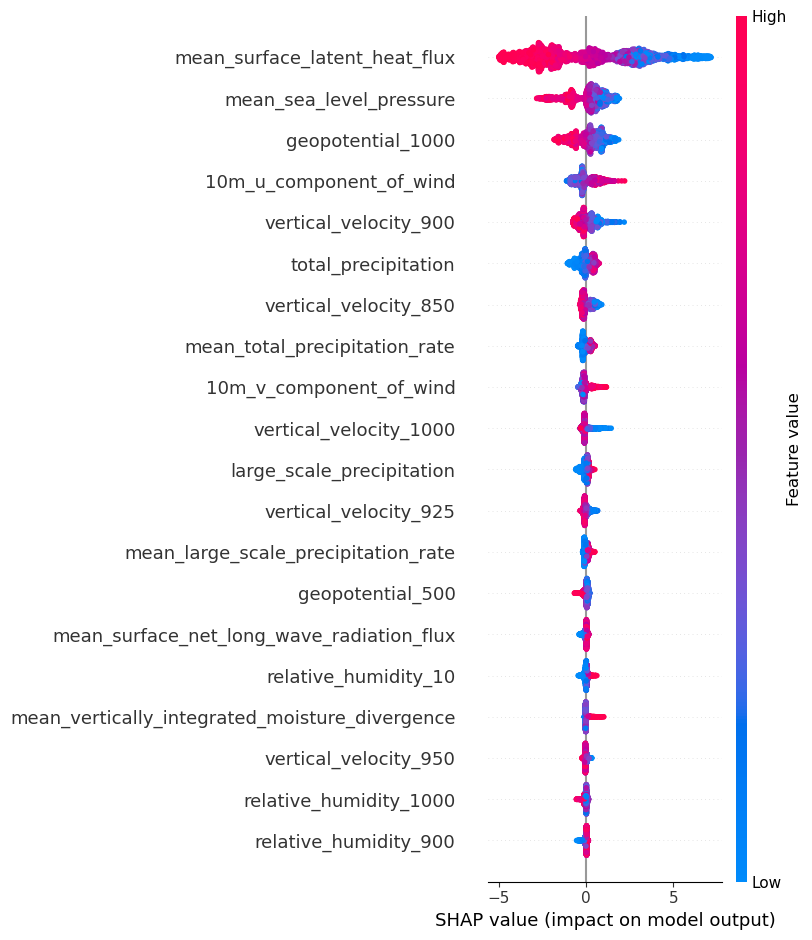

SHAP values for RandomForest
mse with validation set: 5.710333173287104
mse with test set: 5.258858851817984
mae with validation set: 1.8634679618883674
mae with test set: 1.7265429444677018
r2 with validation set: 0.8387871110707846
r2 with test set: 0.8550698759168429


 97%|=================== | 3117/3220 [00:11<00:00]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


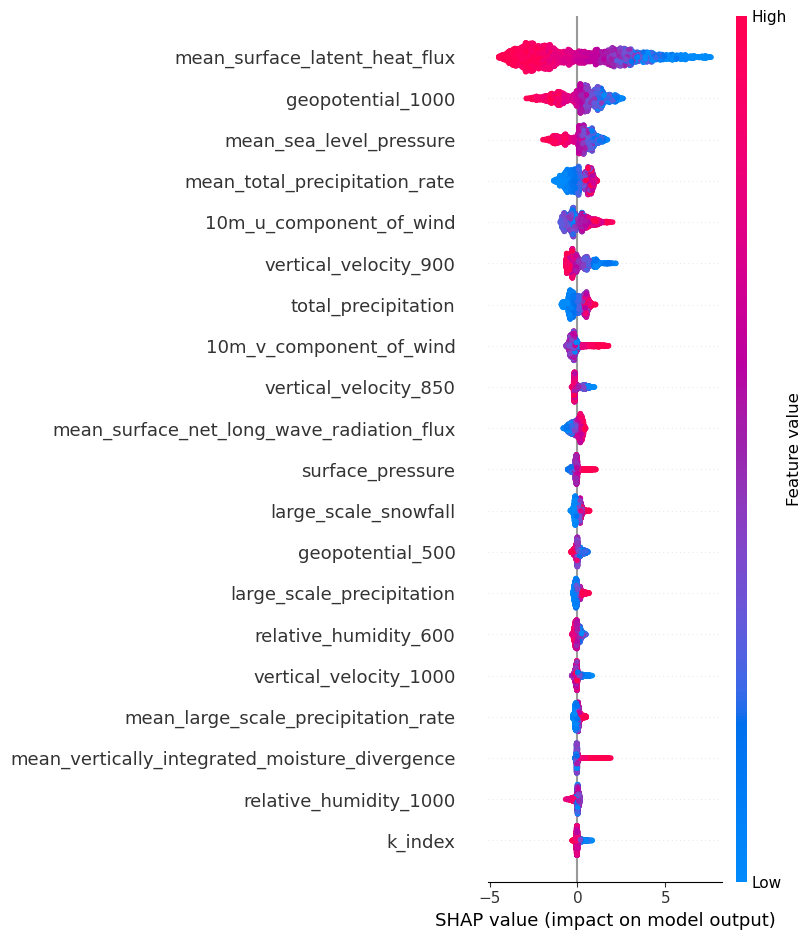

SHAP values for LightGBM
mse with validation set: 4.345865912749023
mse with test set: 4.582937394712525
mae with validation set: 1.6355657512105026
mae with test set: 1.6058663701194
r2 with validation set: 0.8773084551404605
r2 with test set: 0.8736977538289679


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


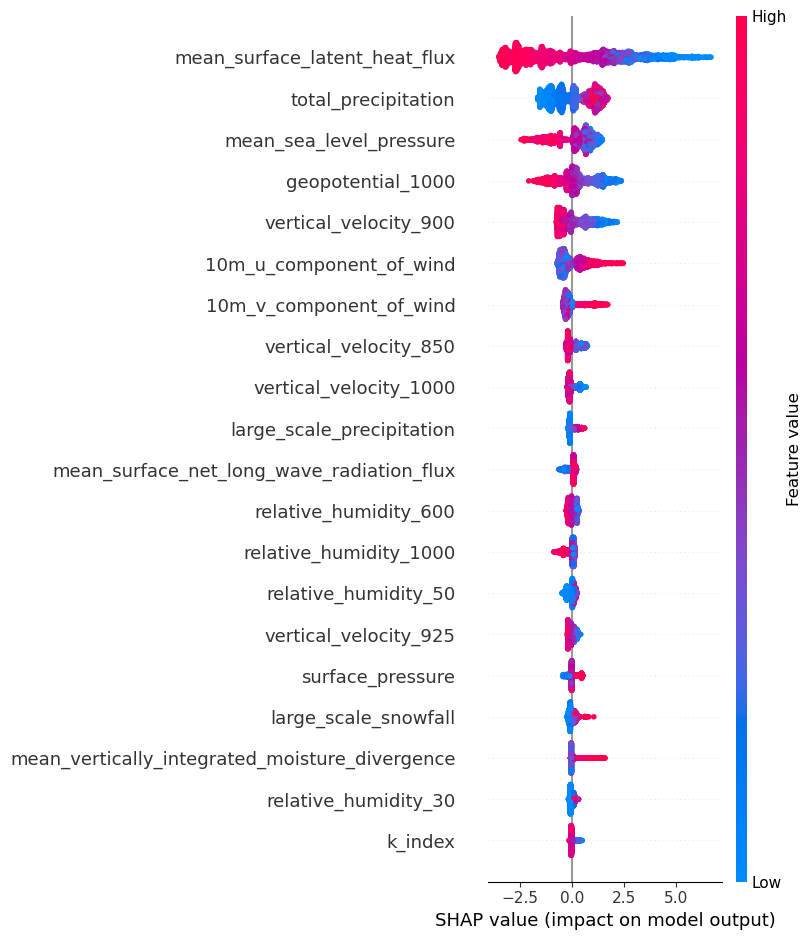

SHAP values for GradientBoosting
mse with validation set: 4.727394064141031
mse with test set: 4.991310680539382
mae with validation set: 1.717942488720164
mae with test set: 1.683069572243233
r2 with validation set: 0.8665372350334694
r2 with test set: 0.8624432986981418


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


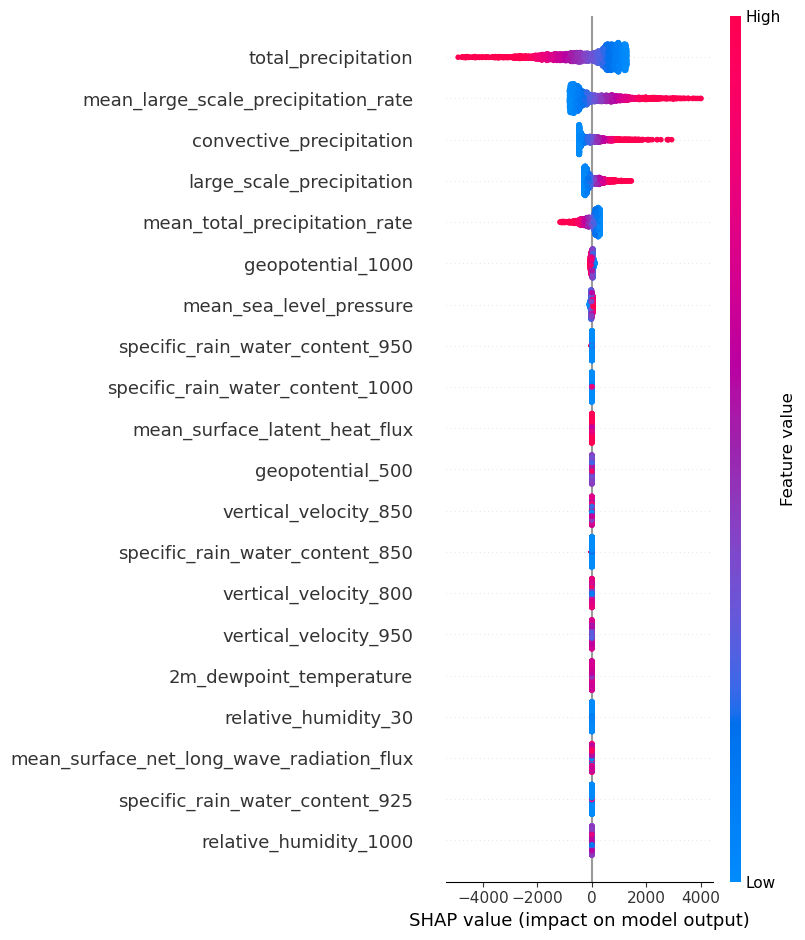

SHAP values for LinearRegression
mse with validation set: 4.754541361407388
mse with test set: 4.596554669168512
mae with validation set: 1.8233071168840984
mae with test set: 1.6497182242628181
r2 with validation set: 0.8657708184188657
r2 with test set: 0.8733224721695451


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


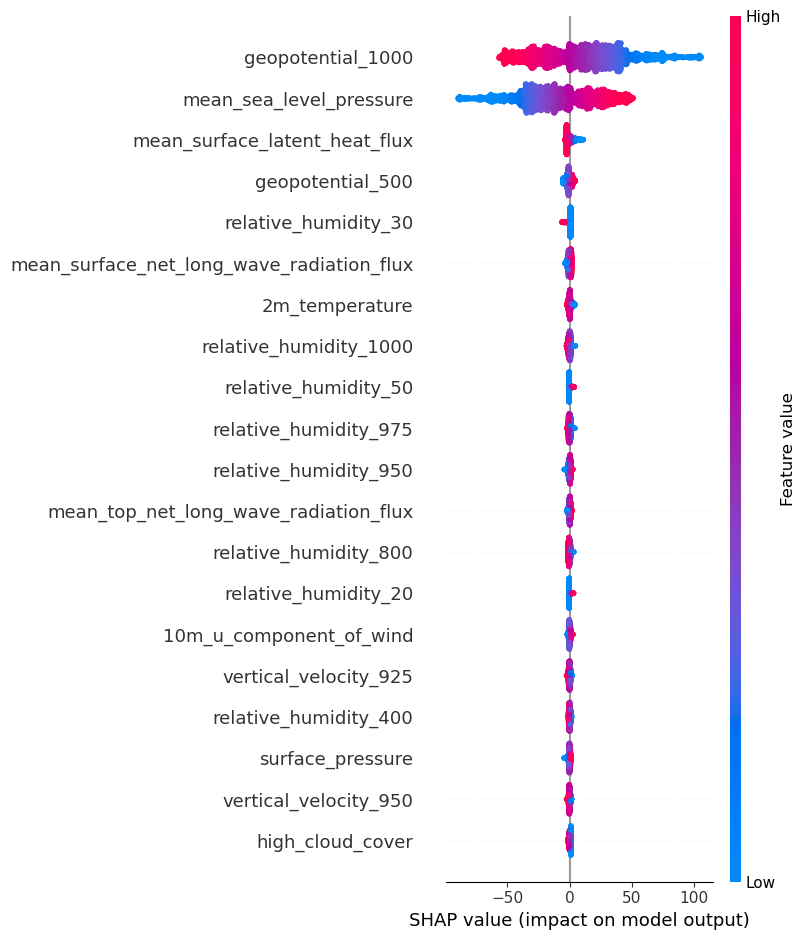

SHAP values for Ridge
mse with validation set: 5.974161053588989
mse with test set: 5.6990528515854715
mae with validation set: 1.9773352336423424
mae with test set: 1.8311865955278006
r2 with validation set: 0.8313387795158932
r2 with test set: 0.8429384662698797


In [11]:
for name, study in studies.items():
    if name == 'XGBoost':
        continue
        shap_values = shap.TreeExplainer(regressors[name]).shap_values(X_test)
        shap_interaction_values = shap.TreeExplainer(regressors[name]).shap_interaction_values(X_test)
        shap.summary_plot(shap_values, X_test, plot_type="bar")
    explainer = shap.Explainer(regressors[name], X_train)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, title=name)
    print(f"SHAP values for {name}")
    print(f"mse with validation set: {mean_squared_error(y_validation, regressors[name].predict(X_validation))}")
    print(f"mse with test set: {mean_squared_error(y_test, regressors[name].predict(X_test))}")
    print(f"mae with validation set: {mean_absolute_error(y_validation, regressors[name].predict(X_validation))}")
    print(f"mae with test set: {mean_absolute_error(y_test, regressors[name].predict(X_test))}")
    print(f"r2 with validation set: {r2_score(y_validation, regressors[name].predict(X_validation))}")
    print(f"r2 with test set: {r2_score(y_test, regressors[name].predict(X_test))}")
    

In [4]:
for name, study in studies.items():
    if name == 'XGBoost' or name == 'RandomForest':
        continue
        shap_values = shap.TreeExplainer(regressors[name]).shap_values(X_test)
        shap_interaction_values = shap.TreeExplainer(regressors[name]).shap_interaction_values(X_test)
        shap.summary_plot(shap_values, X_test, plot_type="bar")
    explainer = shap.Explainer(regressors[name], X_train)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, title=name)
    print(f"SHAP values for {name}, mse with validation set: {mean_squared_error(y_validation, regressors[name].predict(X_validation))}")
    

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: LGBMRegressor()

mse with validation set for RandomForest: 5.929452270224629
mse with test set for RandomForest: 6.065920658969053
mse with train set for RandomForest: 0.0827666226954747


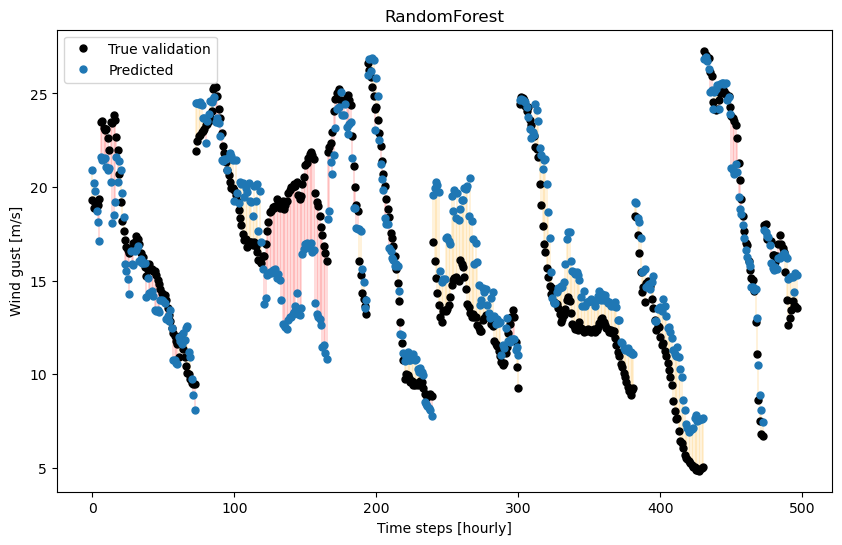

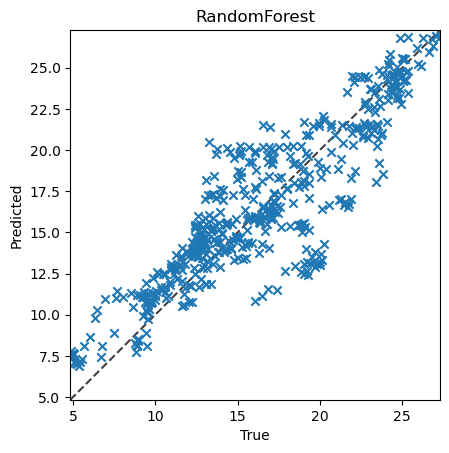

mse with validation set for LightGBM: 5.502255780363145
mse with test set for LightGBM: 5.2909540737138006
mse with train set for LightGBM: 0.11353887763962266


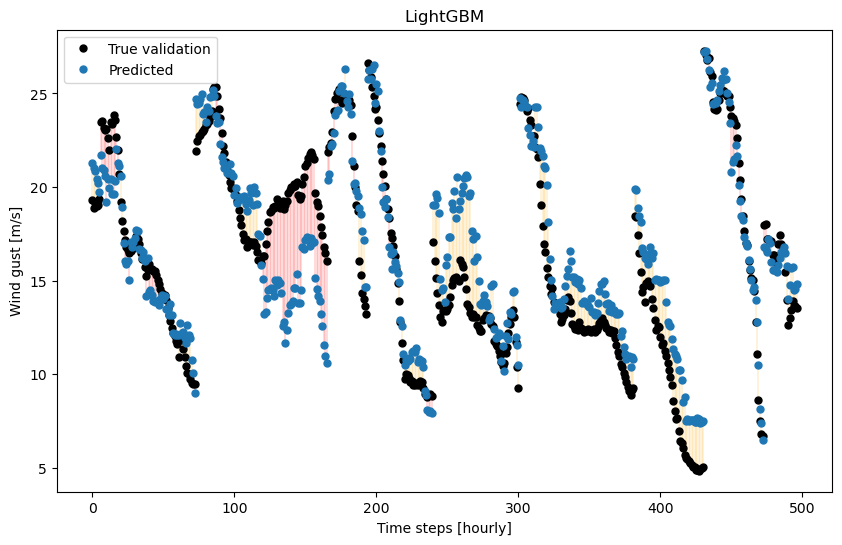

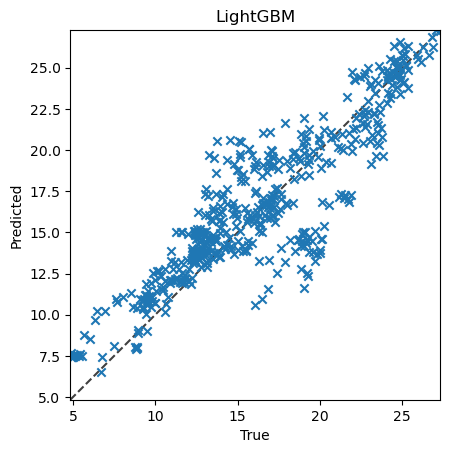

mse with validation set for XGBoost: 6.072021719297901
mse with test set for XGBoost: 5.149497257825466
mse with train set for XGBoost: 0.015654044122460766


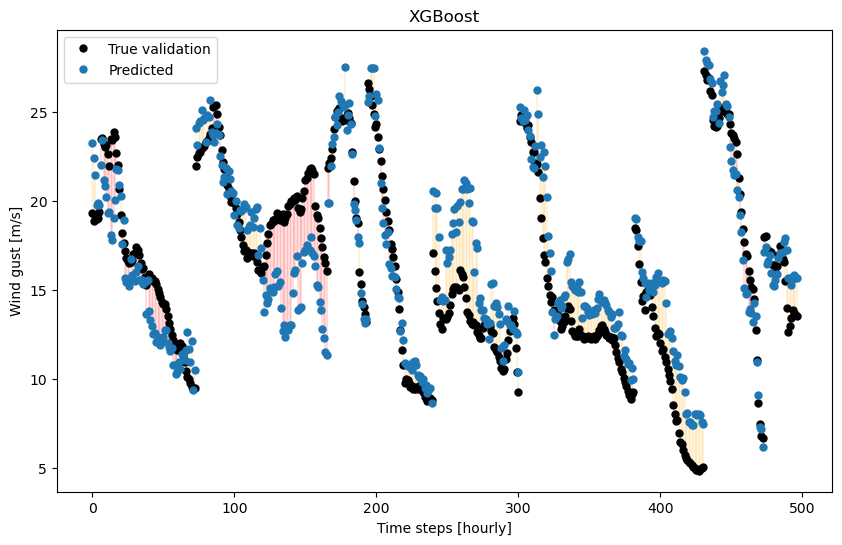

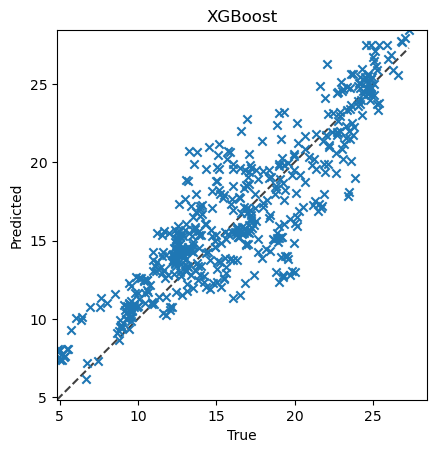

mse with validation set for GradientBoosting: 5.020746150154609
mse with test set for GradientBoosting: 4.992253332316019
mse with train set for GradientBoosting: 0.8732771908192648


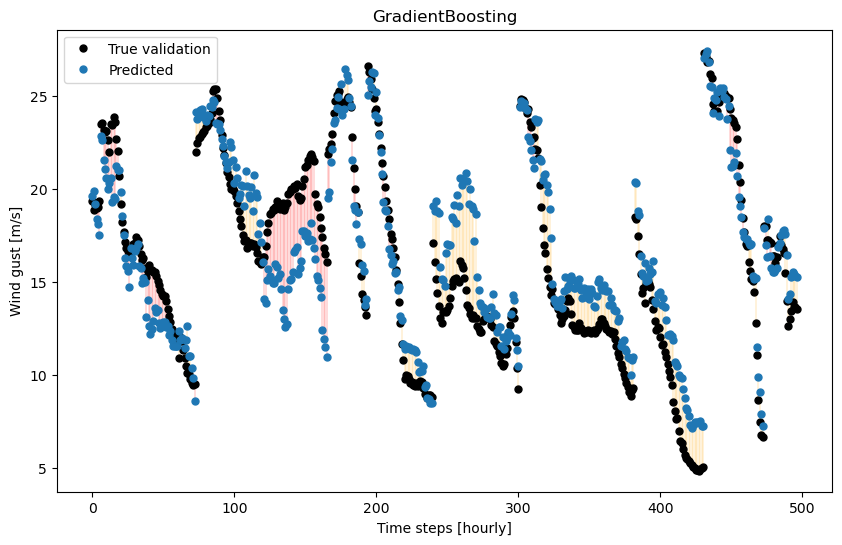

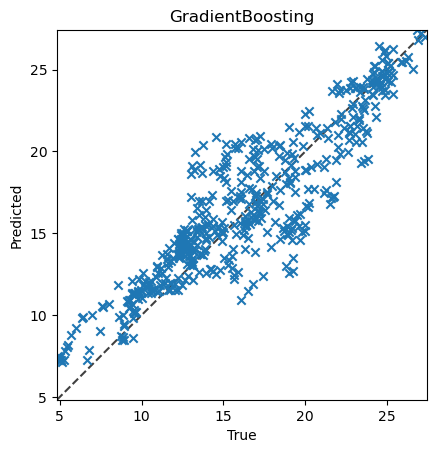

mse with validation set for LinearRegression: 4.041362934992779
mse with test set for LinearRegression: 5.082993278915512
mse with train set for LinearRegression: 2.0006848469475873


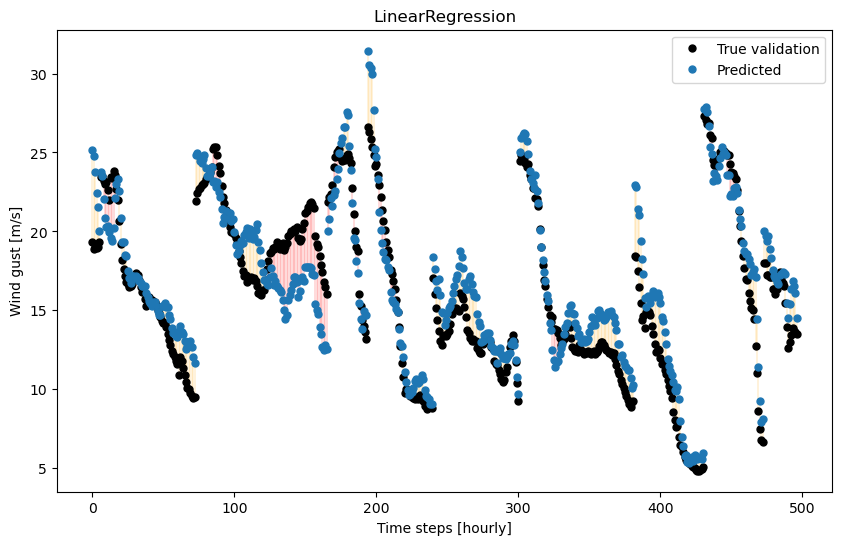

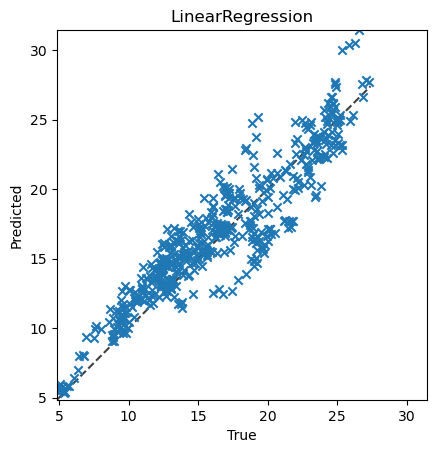

mse with validation set for Ridge: 4.569186264024102
mse with test set for Ridge: 4.751353582448972
mse with train set for Ridge: 2.529769997196271


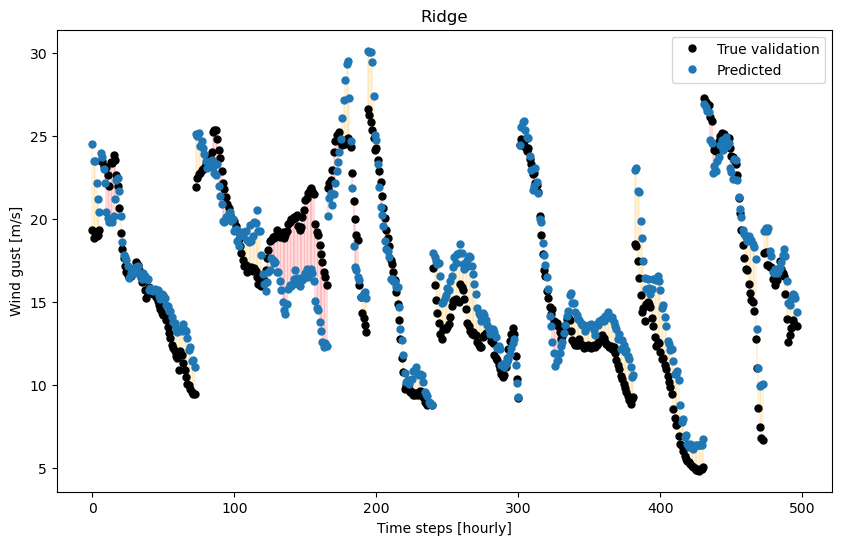

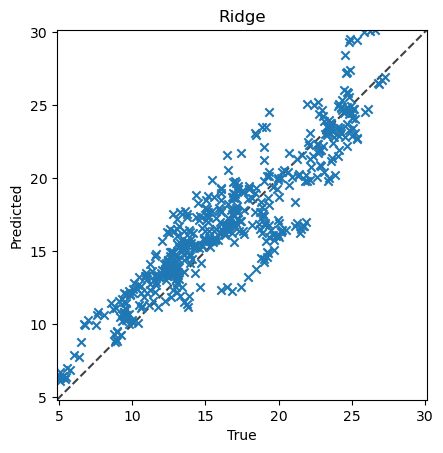

In [66]:
# see the prediction over the validation set for each model using plot

import matplotlib.pyplot as plt

thickness = 0.2

for name, study in studies.items():
    print(f"mse with validation set for {name}: {mean_squared_error(y_validation, regressors[name].predict(X_validation))}")
    print(f"mse with test set for {name}: {mean_squared_error(y_test, regressors[name].predict(X_test))}")
    print(f"mse with train set for {name}: {mean_squared_error(y_train, regressors[name].predict(X_train))}")
    predictions = regressors[name].predict(X_validation)
    errors = y_validation.values.ravel() - predictions

    # Assuming y_validation and X_validation are defined
    predictions = regressors[name].predict(X_validation)
    errors = y_validation.values.ravel() - predictions

    plt.figure(figsize=(10, 6))

    # Add vertical lines for error bars with color based on prediction vs true value
    for i in range(len(predictions)):
        color = 'orange' if predictions[i] > y_validation.values.ravel()[i] else 'red'
        plt.vlines(x=i, ymin=min(y_validation.values.ravel()[i], predictions[i]), ymax=max(y_validation.values.ravel()[i], predictions[i]), color=color, linewidth = thickness)

    plt.plot(y_validation, 'o', color='black', markersize=5, label='True validation')
    plt.plot(predictions, 'o', markersize=5, label='Predicted')

    plt.legend()
    plt.xlabel('Time steps [hourly]')
    plt.ylabel('Wind gust [m/s]')
    plt.title(name)
    plt.show()

    # Add a diagonal line for reference
    plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    plt.scatter(y_validation, regressors[name].predict(X_validation), marker='x')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(name)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

# Set the limits of both axes to be the same
    lims = [
        min(min(y_validation.values.ravel()), min(predictions)),  # min of both axes
        max(max(y_validation.values.ravel()), max(predictions))   # max of both axes
    ]
    plt.xlim(lims)
    plt.ylim(lims)

    plt.show()


In [45]:
y_validation.values.ravel()[i]

19.33121